In [1]:
import sys, os



# Detect if running inside Jupyter
if "__file__" in globals():
    # Running as a .py script
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
else:
    # Running inside Jupyter Notebook
    # Assume notebook is inside project/reproduction/
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

sys.path.append(project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from utils.data_utils_newest import gen_star_from_x1, get_true_frequencies, gen_progressive
from utils.metrics import compute_mse
from utils.spl import random_split_perturb, random_split_estimate
from utils.rs_fd import rs_fd_perturb, rs_fd_estimate
from utils.rs_rfd import rs_rfd_perturb, rs_rfd_estimate
from utils.corr_rr_fixed_new import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,
    optimal_p_y,
    build_p_y_table,
)


mpl.rcParams['pdf.fonttype'] = 42   # TrueType
mpl.rcParams['ps.fonttype'] = 42    # TrueType for EPS


mpl.rc('font', family='DejaVu Serif')


mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['mathtext.fontset'] = 'cm'     # Math font
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30
# ---------------- helpers ----------------
def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}



def _build_p_y_table_minimal(est_I, epsilon, n2, domain, cols):
    return {
        (a, b): float(optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain))
        for a in cols for b in cols if a != b
    }

# ---------------- one-shot runner ----------------
def run_all_once(
    df,
    epsilon,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    cols = list(df.columns)
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

    # SPL
    rpt = random_split_perturb(df, epsilon)
    est = random_split_estimate(rpt, df, epsilon)
    out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

    # RS+FD
    pert_rsfd = rs_fd_perturb(df, domains, epsilon)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, epsilon)
    out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_rsfd[c]) for c in cols])

    # RS+RFD (two-phase)
    est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_rsrfd)
    n1_rsrfd = len(df) - len(df_B_rsrfd)
    n2_rsrfd = len(df_B_rsrfd)
    priors_2p = {col: _normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}
    pert_rsrfd_2p = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors_2p, epsilon)
    est_II_rsrfd = rs_rfd_estimate(pert_rsrfd_2p, doms_rsrfd, priors_2p, epsilon)
    combined_rsrfd = combine_phase_estimates(est_I_rsrfd, est_II_rsrfd, n1_rsrfd, n2_rsrfd)
    out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rsrfd[c]) for c in cols])

    # Corr-RR
    if use_corr_rr:
        est_I, df_B, doms_stable = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_corr)
        n1 = len(df) - len(df_B)
        n2 = len(df_B)
        common_domain = doms_stable[cols[0]]
        p_y_table = _build_p_y_table_minimal(est_I, epsilon, n2, common_domain, cols)
        pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms_stable, p_y_table)
        est_II = corr_rr_estimate(pert_corr, doms_stable, epsilon)
        combined_est = combine_phase_estimates(est_I, est_II, n1, n2)
        out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_est[c]) for c in cols])

    return out



In [20]:
def sweep_rho_all(
    n=10000,
    rhos=(0.1, 0.3, 0.5, 0.7, 0.9),
    epsilon=0.6,
    R=50,
    d=4,
    domain=None,
    x1_marginal=None,
    q_marginal=None,
    plot_dir=None,
    csv_dir=None,
    data_dir=None,  # <--- NEW: raw results directory
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
    file=None, 
):
    """
    Sweep over correlation strength (rho) while fixing epsilon.
    Produces MSE vs rho plot using the STAR dependency generator.
    Saves both averaged and raw MSE data in CSV format.
    """

    if domain is None:
        domain = [0, 1]
    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(rhos)) for k in keys}
    raw_records = []  # store all runs for data_dir CSV

    if seed is not None:
        np.random.seed(seed)

    # =====================================================
    # sweep across rho values
    # =====================================================
    for j, rho in enumerate(rhos):
        df = gen_star_from_x1(
            n=n,
            domain=domain,
            d=d,
            x1_marginal=x1_marginal,
            rho=rho,
            q_marginal=q_marginal,
            seed=seed,
        )

        for run in range(R):
            res = run_all_once(
                df,
                epsilon,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][j] += res[k]
                raw_records.append({
                    "rho": rho,
                    "run": run + 1,
                    "epsilon": epsilon,
                    "mechanism": k,
                    "mse": res[k]
                })

    # average results
    for k in keys:
        means[k] /= R

    # =====================================================
    # plotting
    # =====================================================
    plt.figure(figsize=(10, 8))
    plt.plot(rhos, means["SPL"], '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(rhos, means["RS+FD"], '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(rhos, means["RS+RFD"], '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(rhos, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel(r'$\rho$', fontsize=50)
    plt.ylabel('MSE', fontsize=40)
    plt.xticks(rhos, labels=[str(round(r, 1)) for r in rhos])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    # ---- legend outside top center ----
    legend = plt.legend(
        fontsize=35,
        loc='lower center',
        ncol=2,
        frameon=True,
        edgecolor='black',
        bbox_to_anchor=(0.5, 1.02),
        labelspacing=0.15,
        columnspacing=0.8,
        handletextpad=0.8,
        handlelength=2
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.82)

    base = f"mseVSrho_{d}attr_{len(domain)}domain_n_{n}_eps_{epsilon}"

    # =====================================================
    # save outputs
    # =====================================================

    # --- 1) Save figure ---
    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(
            os.path.join(plot_dir, file + ".pdf"),
            format="pdf",
            bbox_extra_artists=(legend,),
            bbox_inches='tight'
        )
    plt.show()

    # --- 2) Save averaged results (MSE vs rho) ---
    if csv_dir:
        df_out = pd.DataFrame({"rho": list(rhos)})
        for k in keys:
            df_out[k] = means[k]
        os.makedirs(csv_dir, exist_ok=True)
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    # --- 3) Save raw results (all runs) ---
    if data_dir:
        os.makedirs(data_dir, exist_ok=True)
        df_raw = pd.DataFrame(raw_records)
        df_raw.to_csv(os.path.join(data_dir, f"raw_{base}.csv"), index=False)

    return means


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


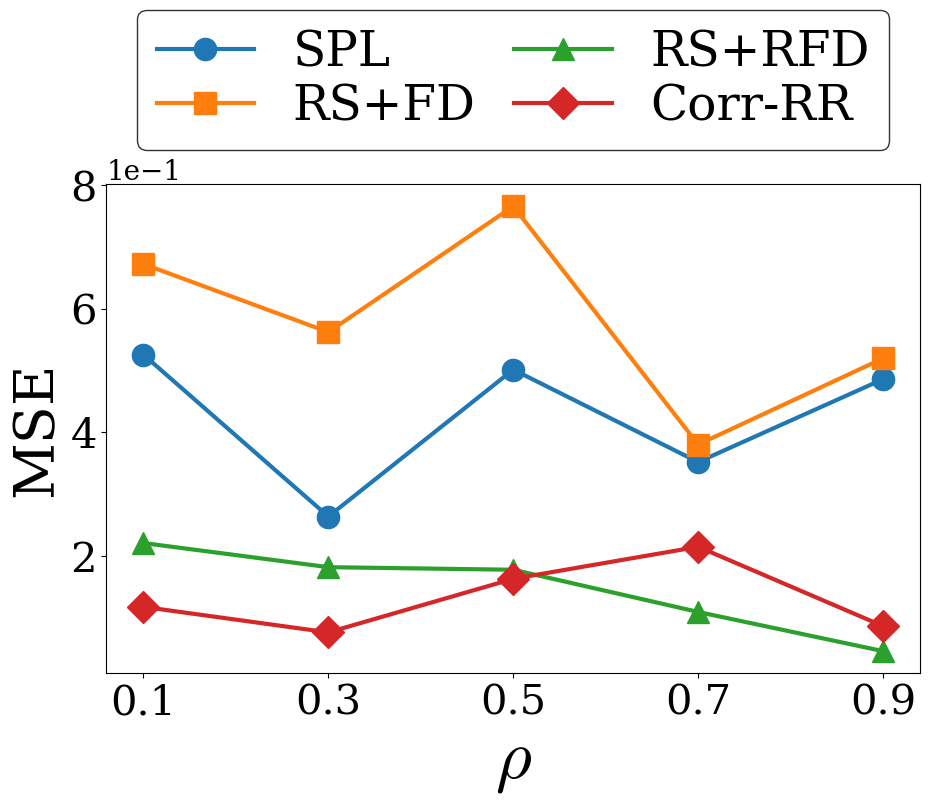

In [21]:

if __name__ == "__main__":
    
    domain = [0, 1, 2, 3]
    x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}
    n = 200
    R = 1
    eps_fixed = 0.5
    rho_values = [0.1, 0.3, 0.5, 0.7, 0.9]
    d=3
    means_rho = sweep_rho_all(
        n=n,
        rhos=rho_values,
        epsilon=eps_fixed,
        R=R,
        d=d,
        seed=42,
        use_corr_rr=True,
        domain=domain,
        x1_marginal=x1_marginal,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir=r"C:\\Users\\ss6365\\Desktop\\Corr-RR\\fig",
        file="fig_8a",
    )

In [2]:
def sweep_rho_all_progressive(
    n=10000,
    rhos=(0.1, 0.3, 0.5, 0.7, 0.9),
    epsilon=0.6,
    R=50,
    d=4,
    domain=None,
    x1_marginal=None,
    q_marginal=None,
    plot_dir=None,
    csv_dir=None,
    data_dir=None,   # NEW: to save all per-run results
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
    file=None,
):
    """
    Sweep over correlation strength (rho) for the PROGRESSIVE model while fixing epsilon.
    Produces MSE vs rho plot and saves averaged + raw results.
    """

    # ---------- Defaults ----------
    if domain is None:
        domain = [0, 1]
    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(rhos)) for k in keys}
    raw_records = []  # to store per-run results

    if seed is not None:
        np.random.seed(seed)

    # =====================================================
    # Sweep across rho values
    # =====================================================
    for j, rho in enumerate(rhos):
        df = gen_progressive(
            n=n,
            domain=domain,
            d=d,
            x1_marginal=x1_marginal,
            rho=rho,
            q_marginal=q_marginal,
            seed=seed,
        )

        for run in range(R):
            res = run_all_once(
                df,
                epsilon,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][j] += res[k]
                raw_records.append({
                    "rho": rho,
                    "run": run + 1,
                    "epsilon": epsilon,
                    "mechanism": k,
                    "mse": res[k]
                })

    # Average MSEs
    for k in keys:
        means[k] /= R

    # =====================================================
    # Plotting
    # =====================================================
    plt.figure(figsize=(10, 8))
    plt.plot(rhos, means["SPL"], '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(rhos, means["RS+FD"], '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(rhos, means["RS+RFD"], '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(rhos, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel(r'$\rho$', fontsize=50)
    plt.ylabel('MSE', fontsize=40)
    plt.xticks(rhos, labels=[str(round(r, 1)) for r in rhos])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    # Legend outside top center
    legend = plt.legend(
        fontsize=35,
        loc='lower center',
        ncol=2,
        frameon=True,
        edgecolor='black',
        bbox_to_anchor=(0.5, 1.02),
        labelspacing=0.15,
        columnspacing=0.8,
        handletextpad=0.8,
        handlelength=2
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.82)

    # =====================================================
    # Save Outputs
    # =====================================================
    base = f"mseVSrho_progressive_{d}attr_{len(domain)}domain_n_{n}_eps_{epsilon}"

    # 1) Figure
    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(
            os.path.join(plot_dir, file + ".pdf"),
            format="pdf",
            bbox_extra_artists=(legend,),
            bbox_inches='tight'
        )
    plt.show()

    # 2) Averaged MSE (MSE vs rho)
    if csv_dir:
        df_out = pd.DataFrame({"rho": list(rhos)})
        for k in keys:
            df_out[k] = means[k]
        os.makedirs(csv_dir, exist_ok=True)
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    # 3) Raw all-run results
    if data_dir:
        os.makedirs(data_dir, exist_ok=True)
        df_raw = pd.DataFrame(raw_records)
        df_raw.to_csv(os.path.join(data_dir, f"raw_{base}.csv"), index=False)

    return means


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


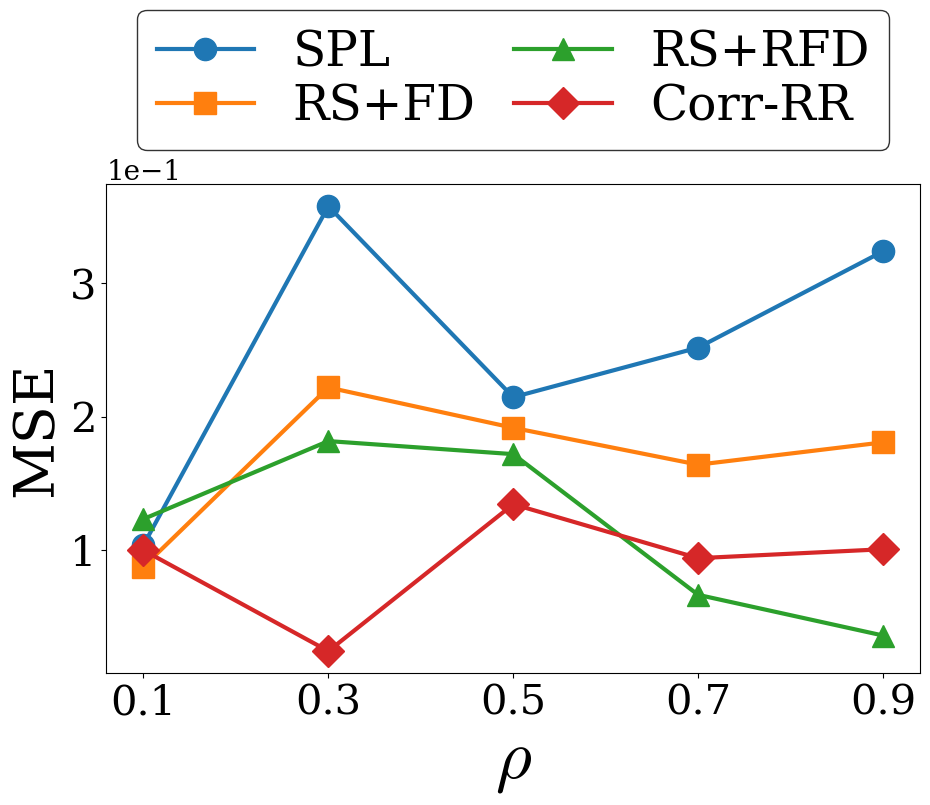

In [3]:

if __name__ == "__main__":
    
    domain = [0, 1, 2, 3]
    x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}
    n = 200
    R = 1
    eps_fixed = 0.5
    rho_values = [0.1, 0.3, 0.5, 0.7, 0.9]
    d=2
    means_rho = sweep_rho_all_progressive(
        n=n,
        rhos=rho_values,
        epsilon=eps_fixed,
        R=R,
        d=d,
        seed=42,
        use_corr_rr=True,
        domain=domain,
        x1_marginal=x1_marginal,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir=r"C:\\Users\\ss6365\\Desktop\\Corr-RR\\fig",
        file="fig_7a",
    )